# ELEC474 Project

In [407]:
import cv2 as cv
import numpy as np
import os
import operator
import copy
import random
import math
import time
from cv2 import Stitcher
from matplotlib import pyplot as plt

In [408]:
global my_SIFT_instance, my_BF_instance
my_SIFT_instance = cv.SIFT_create()

FLANN_INDEX_KDTREE = 0 #heard from C++ api that this should be 1
# FLANN_INDEX_KDTREE = 1

dirName1 = 'office2'
dirName2 = 'StJames'
dirName3 = 'WLH'

imgDescipt_1 = np.array((
"Left Key Point",
"Right Key Points"
))

imgDescipt_2 = np.array((
"Select point Output",
"Epipolar Line Output"
))

WINDOW_NAME1 = "1.2 Output Image_1"
WINDOW_NAME2 = "1.2 Output Image_2"
WINDOW_NAME3 = "1.3 Input left"
WINDOW_NAME4 = "1.3 Input Right"
WINDOW_NAME5 = "1.3 output 1"
WINDOW_NAME6 = "1.3 output 2"

Process_BarLength = 30

BEST_MATCH_METRIC = 350 #StJames is 85, office2 is 200, WLH is 100
LOWE_RATIO = 0.7
SEED_IDX = 14

# Step 1

In [409]:
class MatcheClass:
    def __init__(self, kp, des):
        self.kp = kp
        self.des = des
    
    def LoadMatch(self, match):
        self.matchs = match
    
    def LoadImg(self, img):
        self.img = img
    
    def __eq__(self, other) -> bool:
        return self.__dict__ == other.__dict__
        

In [410]:
def PltImg(img,imgDescipt):
    plt.figure(dpi=300)
    plt.figure(figsize=(15,15))
    idx = len(img)
    for i in range(idx):
        plt.subplot(1,idx,i+1)

        if(len(img[i].shape) == 2): #differ from gray and color img 
            plt.imshow(img[i],cmap="gray")
        else:
            plt.imshow(cv.cvtColor(img[i], cv.COLOR_BGR2RGB))

        plt.title(imgDescipt[i])
    plt.tight_layout()

def ReadImgs(dirName, imgName):
    return cv.imread(os.getcwd()+'//'+dirName+'//'+imgName)

def FetchingImgs(dirName):
    #list all the img file under dir 
    ls = []
    dir = os.getcwd()+'//'+dirName
    files = os.listdir(dir)
    for filename in files:
        # print(dir + os.sep + filename)

        if os.path.splitext(filename)[1] == '.jpg':
            ls.append(filename)
    if ls.count != 0:
        print("Detected: \n",ls)
    return ls

def ProgressionBarUpdate(current,overall):
    pctge = (current+1) / overall
    if pctge > 1:
        pctge = 1
    temp = int(round(Process_BarLength * pctge))
    print('\r%s%s%s%s'% ((temp)*'█',(Process_BarLength-temp)*'░',str(round(pctge*100)),'%'), end = ' ')


In [411]:
def FindDescriptorAndKeyPoints(img,descriptor,flag): #when img is BGR image, set flag to 1
    imgGray = img
    if flag == 1:
        imgGray = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    kp, des = descriptor.detectAndCompute(imgGray,None)
    return MatcheClass(kp, des)

def FlannBasedMatchLoweRatio(descriptor1,descriptor2,   
                            flann_Instance,
                            kNum = 2, ratio = 0.7):
    matches = flann_Instance.knnMatch(descriptor1,descriptor2,k = kNum)

    loweMatch = []
    for m,n in matches:
        if m.distance < ratio * n.distance:
            loweMatch.append(m)
    return loweMatch

In [412]:

def Matching(img1, img2, descriptor = my_SIFT_instance, loweRatio = LOWE_RATIO):
    #FLANN para and create
    index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search_params = dict(checks = 50)       #or pass empty dict #It specifies the number of times the trees in the index should be recursively traversed.
    flann_Instance = cv.FlannBasedMatcher(index_params,search_params)
    
    #Find img is colored or gray scale
    flag = 0
    if(len(img1.shape) == 3):
        flag = 1
    
    kpDes_1 = FindDescriptorAndKeyPoints(img1, descriptor, flag)
    kpDes_2 = FindDescriptorAndKeyPoints(img2, descriptor, flag) 
    matches = FlannBasedMatchLoweRatio(kpDes_1.des, kpDes_2.des,
                            flann_Instance,
                            kNum = 2, ratio = loweRatio)  #NOTE: The ratio difference of lowe will result in different epiploar lines 
    
    kpDes_2.LoadMatch(matches)
    kpDes_2.LoadImg(img2)
    return kpDes_1, kpDes_2

In [413]:

def MatchingFeaturesOfImages(dirName, descriptorMethod = 'sift'):
    idx = 0
    numGoodMatch = 0
    imgList = []
    matchList = []

    # detect and extract features from the image
    if descriptorMethod == 'sift':
        descriptor = cv.xfeatures2d.SIFT_create()
    elif descriptorMethod == 'surf':
        descriptor = cv.xfeatures2d.SURF_create()
    elif descriptorMethod == 'brisk':
        descriptor = cv.BRISK_create()
    elif descriptorMethod == 'orb':
        descriptor = cv.ORB_create()
    
    print("Featching Images under Dir and creating descriptors for them")
    imgNameList = FetchingImgs(dirName)
    for imgName in imgNameList:
        idx += 1
        ProgressionBarUpdate(idx, len(imgNameList)+1)
        
        temp = ReadImgs(dirName, imgName)
        imgList.append(temp)
        

    seedIdx = SEED_IDX
    seedImg = imgList[seedIdx]
    print("\nYour Seed Idex from Imgaes is", SEED_IDX, "And Your Seed Image Looks like:")
    PltImg([seedImg],["Seed Image"])
    
    print("\nFinding best Match for each pair of imgs")
    imgListIdx = list(range(len(imgList)))
    imgListIdx.remove(seedIdx)
    for imgIdx in imgListIdx:
        ProgressionBarUpdate(imgIdx+1,len(imgList)-1)
        seedPara,compare = Matching(seedImg, imgList[imgIdx],descriptor)
        if len(compare.matchs) > BEST_MATCH_METRIC:
            matchList.append(compare)
            numGoodMatch += 1
    seedPara.LoadImg(seedImg)
            
    
    print("\nThere are", numGoodMatch, "good Image Pairs has been find")
        
    return seedPara,matchList

        

Featching Images under Dir and creating descriptors for them
Detected: 
 ['20191119_170646.jpg', '20191119_170650.jpg', '20191119_170652.jpg', '20191119_170653.jpg', '20191119_170655.jpg', '20191119_170657.jpg', '20191119_170658.jpg', '20191119_170700.jpg', '20191119_170702.jpg', '20191119_170704.jpg', '20191119_170706.jpg', '20191119_170707.jpg', '20191119_170709.jpg', '20191119_170711.jpg', '20191119_170712.jpg', '20191119_170714.jpg', '20191119_170715.jpg', '20191119_170717.jpg', '20191119_170719.jpg', '20191119_170721.jpg', '20191119_170723.jpg', '20191119_170725.jpg', '20191119_170727.jpg', '20191119_170729.jpg', '20191119_170730.jpg', '20191119_170732.jpg', '20191119_170733.jpg', '20191119_170735.jpg', '20191119_170737.jpg']
██████████████████████████████100% 
Your Seed Idex from Imgaes is 14 And Your Seed Image Looks like:

Finding best Match for each pair of imgs
██████████████████████████████100% 
There are 4 good Image Pairs has been find


<Figure size 1800x1200 with 0 Axes>

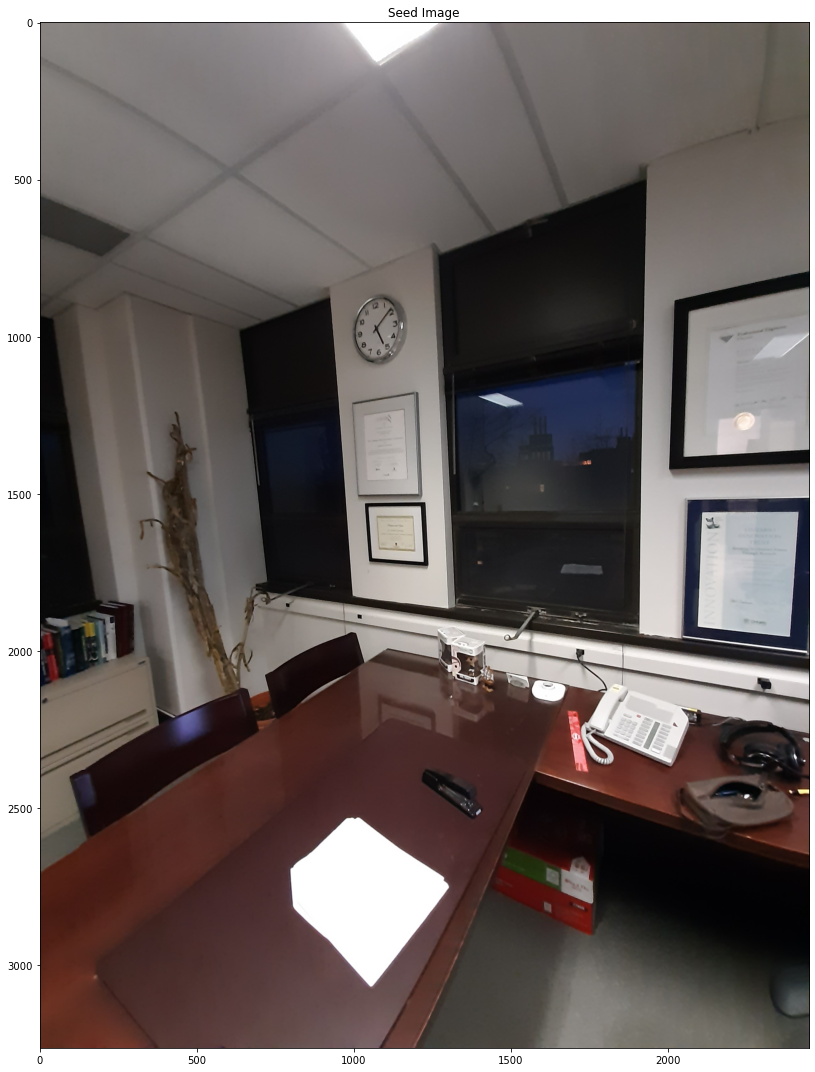

In [414]:

seedPara, mList = MatchingFeaturesOfImages(dirName1)

# for x in mList:
#     PltImg([seedPara.img, x.img],["Seed Img","Good Match Img"])


# Step 2,3

In [415]:
def RLListClasification(mList:MatcheClass, seedPara:MatcheClass):
    leftList = []
    rightList = []
    for currentPair in mList:
        
        height_src, width_src = seedPara.img.shape[:2]
        H = FindHomographic(seedPara.kp, currentPair.kp,currentPair.matchs)
        pts = np.float32(
        [[0, 0], [0, height_src], [width_src, height_src], [width_src, 0]]
        ).reshape(-1, 1, 2)
        direction = cv.perspectiveTransform(pts, H)
        
        if direction[0][0][0] < 0: 
            print("is Left Image")
            # PltImg([seedImg, cmprImg], ["L compare", "L source"])
            leftList.append(currentPair)
        else:
            print("is Right Imgae")
            rightList.append(currentPair)
            # PltImg([seedImg, cmprImg], ["R compare", "R source"]
            
    #Sort from large matchs to low matches
    leftList.sort(key = lambda para:len(para.matchs), reverse=False) 
    rightList.sort(key = lambda para:len(para.matchs), reverse=True) 
    return leftList, rightList
    


In [416]:
def FindHomographic(kp1, kp2, match):

    ref_pts = np.float32([kp1[m.queryIdx].pt for m in match]).reshape(-1,1,2)
    img_pts = np.float32([kp2[m.trainIdx].pt for m in match]).reshape(-1,1,2)

    H, _ = cv.findHomography(ref_pts, img_pts, cv.RANSAC, 5)
    
    return H

In [417]:
leftList, rightList = RLListClasification(mList, seedPara)
# PltImg([seedPara.img],["Seed"])
# for i in leftList[:]:
#     PltImg([i.img],["left"])
#     print(len(i.matchs))
# for i in rightList[:]:
#     PltImg([i.img],["right"])
#     print(len(i.matchs))

is Right Imgae
is Right Imgae
is Left Image
is Left Image


In [418]:
def ChopBlackSide(img):
    
    image = img 
    img = cv.medianBlur(image, 5)
    gray_img = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    _, th = cv.threshold(gray_img, 1, 255, cv.THRESH_BINARY)
    contour, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
    cnt = contour[0]
    x,y,w,h = cv.boundingRect(cnt)
    cropImg = img[y:y+h, x:x+w]
    # PltImg([cropImg],"Chop")
    return cropImg

def StichImgesPair(imgMain, imgWarp):
    print(imgMain.shape)
    print(imgWarp.shape)
    # imgMainSize = imgMain.shape[:2]
    # imgWarpSize = imgWarp.shape[:2]
    warpBuffer = [imgMain.shape[1] + imgWarp.shape[1], imgMain.shape[0]+imgWarp.shape[0]]
    print(warpBuffer)
    img1Para, img2Para = Matching(imgMain, imgWarp)
    H = FindHomographic(img1Para.kp, img2Para.kp,img2Para.matchs)
    H = np.linalg.inv(H)
    
    warpImg = cv.warpPerspective(imgWarp, H, warpBuffer)
    warpImg[0:imgMain.shape[0], 0:imgMain.shape[1]] = imgMain
    warpImg = ChopBlackSide(warpImg)
    PltImg([warpImg, imgMain, imgWarp], ["Warped", "Source", "Append"])
    
    return warpImg

(3264, 2448, 3)
(3264, 2448, 3)
[4896, 6528]
(3264, 2448, 3)
(3841, 2448, 3)
[4896, 7105]
(3264, 2448, 3)
(3770, 3195, 3)
[5643, 7034]
(3264, 2448, 3)
(5944, 5643, 3)
[8091, 9208]


<Figure size 1800x1200 with 0 Axes>

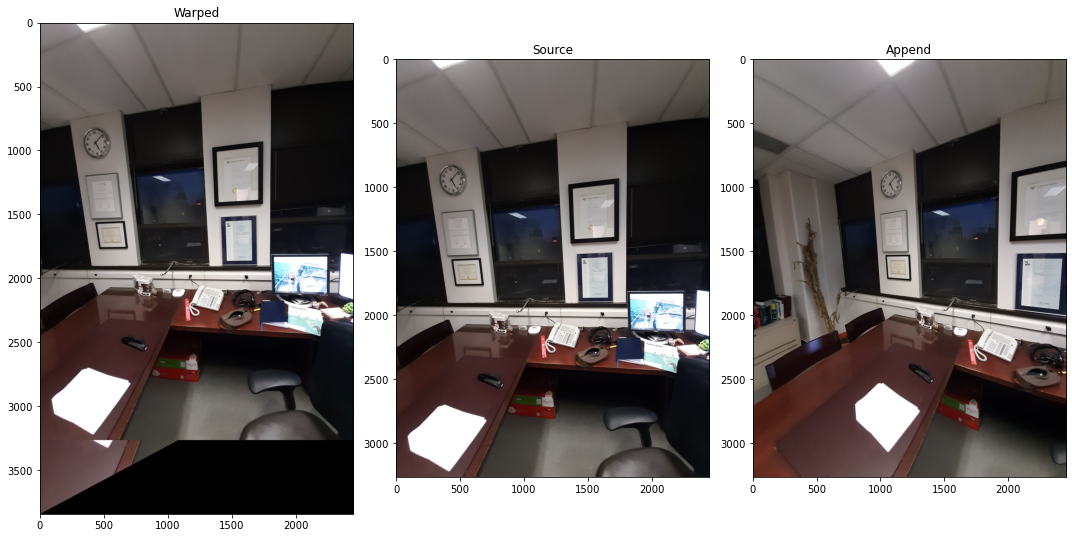

<Figure size 1800x1200 with 0 Axes>

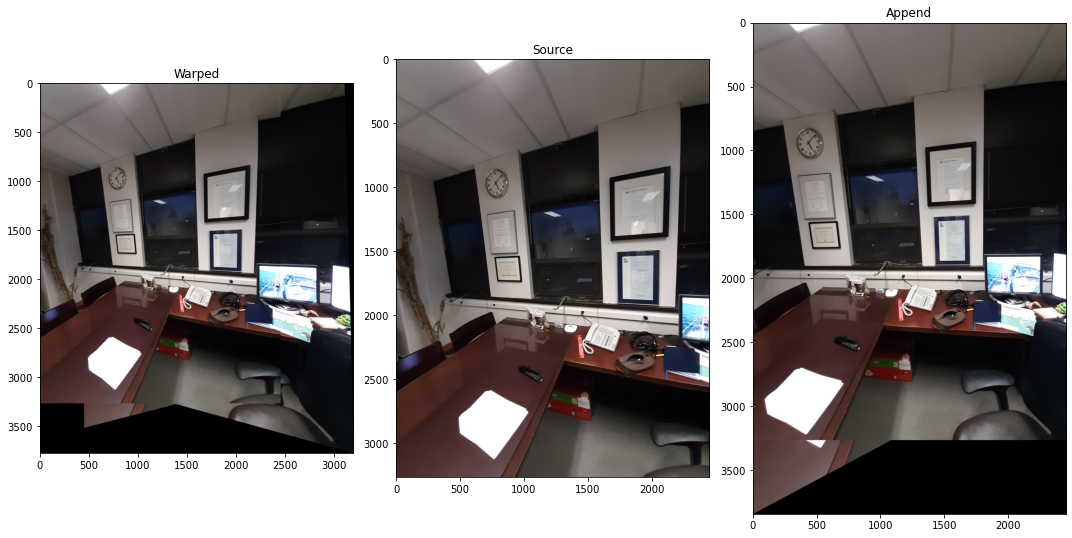

<Figure size 1800x1200 with 0 Axes>

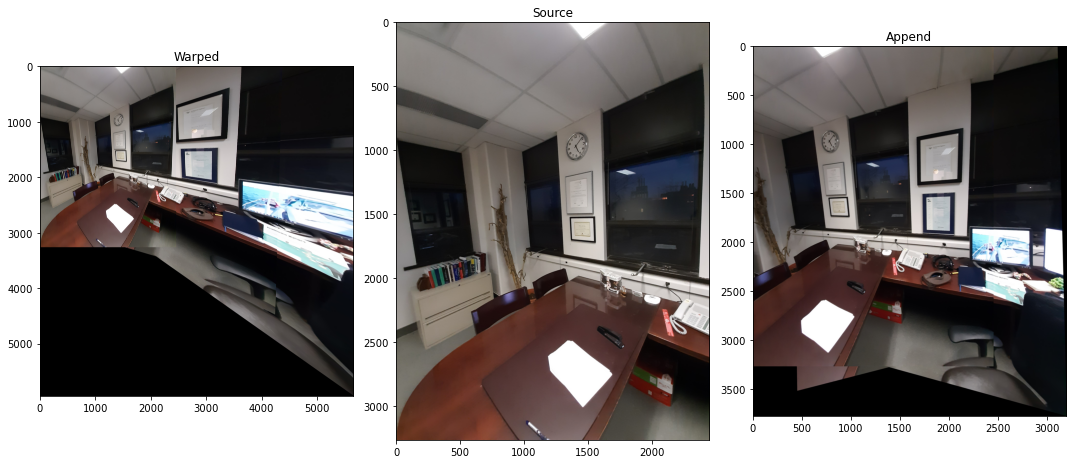

<Figure size 1800x1200 with 0 Axes>

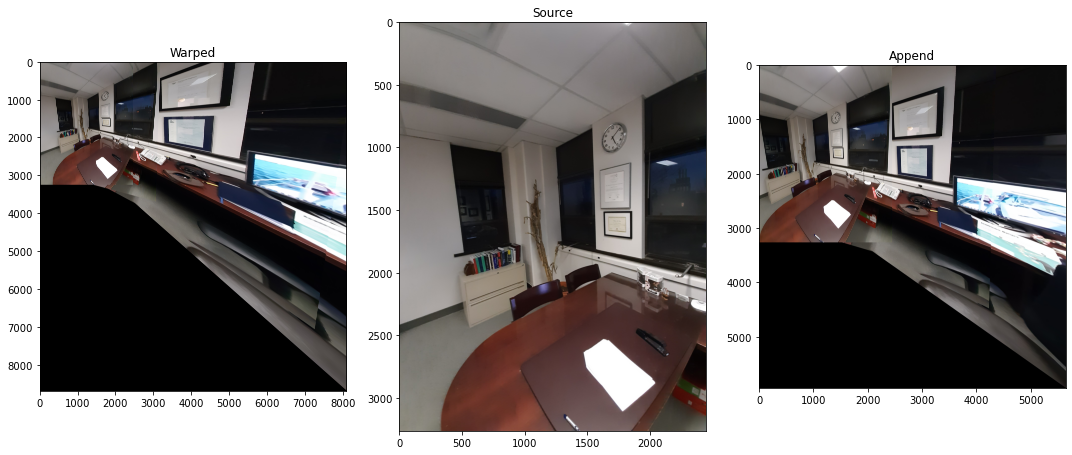

<Figure size 1800x1200 with 0 Axes>

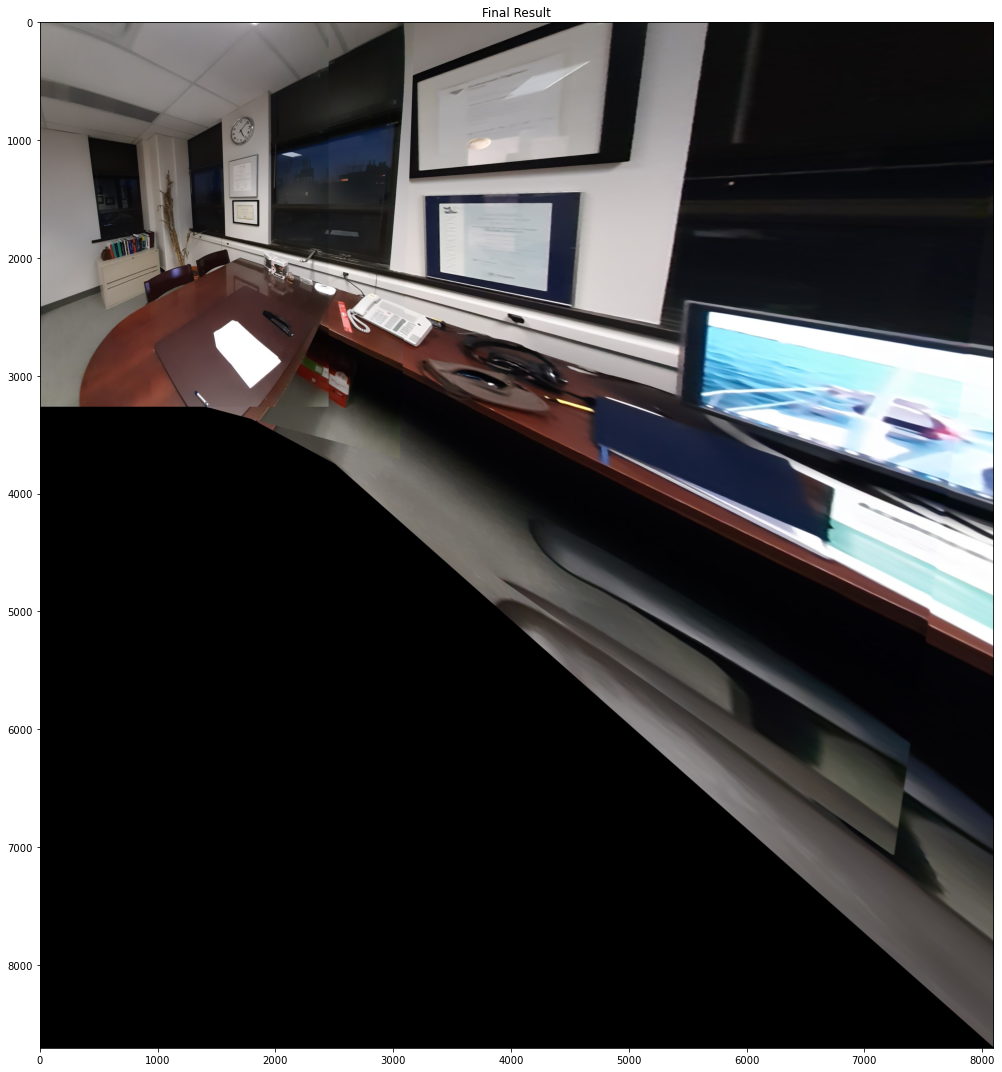

In [419]:
init = StichImgesPair(leftList[0].img, seedPara.img)

for currentLeft in leftList[1:]:
    init = StichImgesPair(currentLeft.img, init) 
for currentRight in rightList[:]:
    init = StichImgesPair(currentRight.img, init) 

PltImg([init], ["Final Result"])